In [3]:
%pip install -r requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import ipywidgets as widgets
from IPython.display import display, Markdown, JSON, clear_output
import textwrap
import helpers as aws
import os, json
from tabulate import tabulate
import cv2 
import matplotlib.pyplot as plt 
from contextlib import contextmanager
import textwrap
import numpy as np

local_images = [f for f in os.listdir('.') if f.endswith('.jpg')]

@contextmanager
def image_spinner(out):
    image = open('spinner.gif', 'rb').read()
    with out:
        clear_output()
        display(widgets.Image(value=image, width=100))
        yield
        clear_output()


def print_wrapped(text, width=80):
    for line in textwrap.wrap(text, width):
        print(line)

# Traditional Feature Engineering

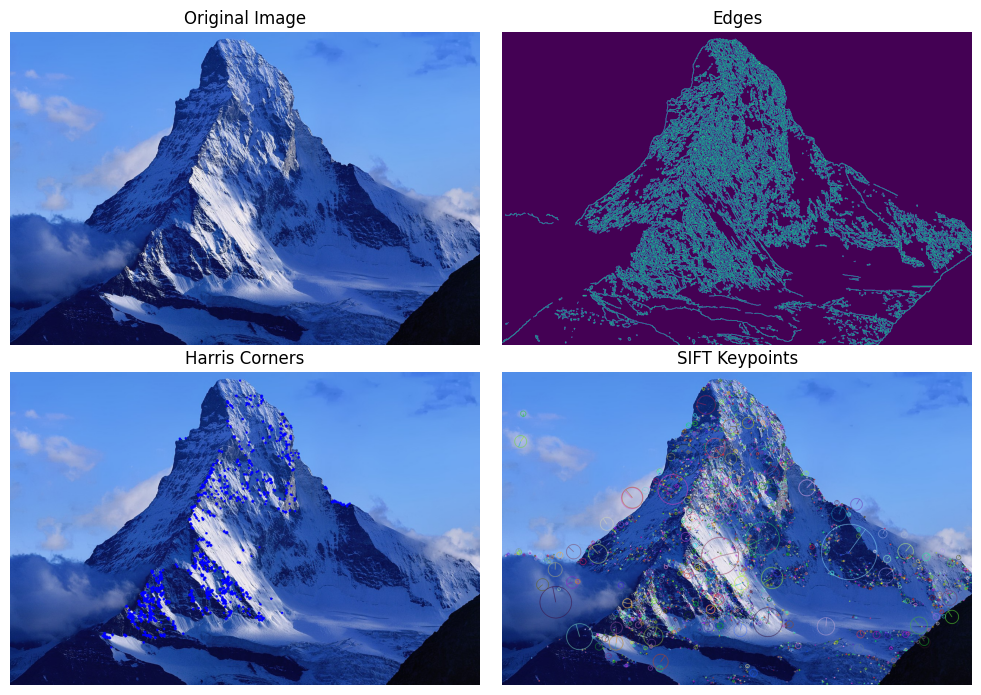

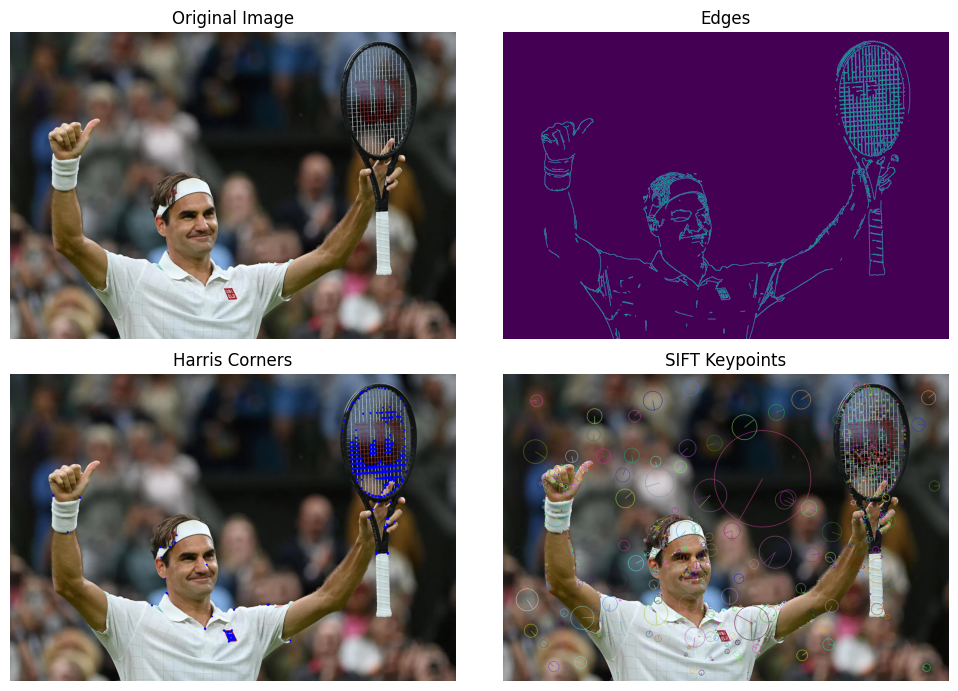

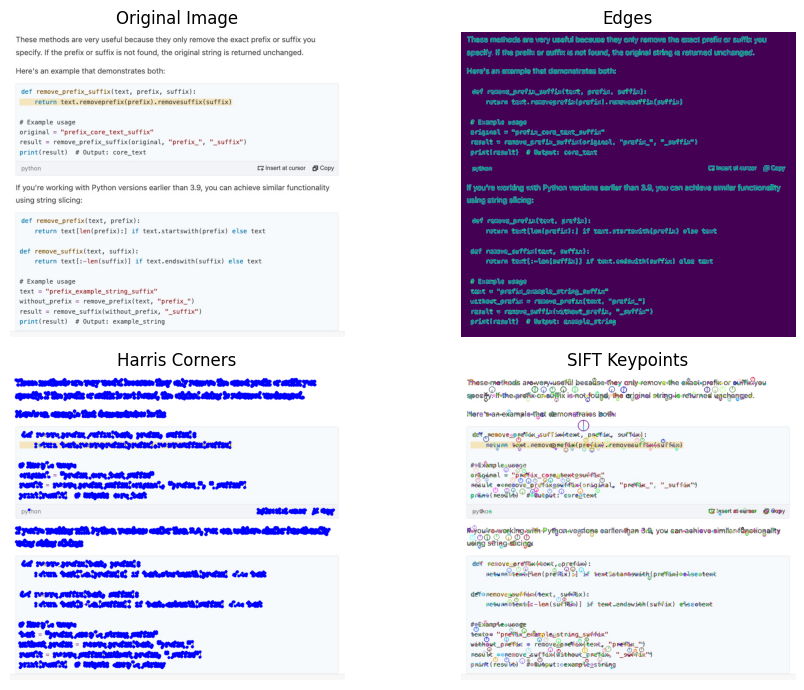

In [5]:
def plot_image_edges(file):
    # Load the image
    image = cv2.imread(file) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Display the original image and the edges
    plt.figure(figsize=(10,7))
    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.axis("off")
    plt.imshow(image)

    # display canny edges
    edges = cv2.Canny(gray, 100, 200)
    plt.subplot(2, 2, 2)
    plt.title('Edges')
    plt.axis("off")
    plt.imshow(edges)

    # display harris corners
    dst = cv2.cornerHarris(gray, 3, 5, 0.1)
    corners = dst > 0.05 * dst.max()
    coord = np.argwhere(corners)
    img = image.copy()
    for y, x in coord:
        cv2.circle(img, (x, y), 3, (0, 0, 255), -1)

    plt.subplot(2, 2, 3)
    plt.title('Harris Corners')
    plt.axis("off")
    plt.imshow(img)

    # display sift features
    sift = cv2.SIFT_create()
    keypoints = sift.detect(gray, None)
    img = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.subplot(2, 2, 4)
    plt.title('SIFT Keypoints')
    plt.axis("off")
    plt.imshow(img)

    plt.tight_layout()
    plt.show()

for file in local_images:
    plot_image_edges(file)

# GenAI based feature engineering

In [6]:
prompts = aws.image_prompts.list()

out_image = widgets.Output(layout = {'padding': '0px 50px', 'max_width': '400px'})
out_text = widgets.Output(layout = {'padding': '0px 50px', 'max_width': '1000px'})

opt_image = widgets.Dropdown(description='images', options=local_images, value=None)
opt_prompt = widgets.Dropdown(description='prompt', options=prompts, value=None)

image = None

def on_image_change(*args):
    global image
    opt_prompt.value = None
    out_text.clear_output()
    image = open(opt_image.value, 'rb').read()
    with out_image:
        clear_output()
        display(widgets.Image(value=image,width=300))

def on_prompt_change(*args):
    text = ""
    if image == None: return
    with image_spinner(out_text):
        text = aws.create_image_description(image, opt_prompt.value)

    with out_text:
        clear_output()
        display(Markdown(text))


# observe changes
opt_image.observe(on_image_change, 'value')
opt_prompt.observe(on_prompt_change, 'value')

# display
form_data = widgets.GridBox([opt_image, opt_prompt], layout = {'margin': '0px 0px 20px', 'grid_template_columns': 'min-content min-content'})
display(widgets.VBox([form_data, widgets.HBox([out_image, out_text])]))

In [ ]:
import time
mp3_s3_location = 's3://drweb-playground/media/podcast-swissgerman.mp3'
aws.s3_download_location(mp3_s3_location)

job = aws.TranscribeJob('podcast-swissgerman-2', mp3_s3_location, 'de-CH')
job.start()

max_count = 300
progress = widgets.IntProgress(
    value=0,
    min=0,
    max=max_count,
    step=1,
    description='Transcribing:',
    bar_style='success',
    orientation='horizontal',
    layout=widgets.Layout(width='50%')
)
display(progress)

count = 0
while count <= max_count:
    progress.value = count
    if job.is_finished(): 
        break
    time.sleep(1)
    count += 1

text = job.get_transcript()
Markdown(text)


In [ ]:
summary = aws.summarize_text(text)
Markdown(summary)

In [ ]:
key_words = aws.keywords_text(text)
Markdown(key_words)